In [1]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from requests.exceptions import HTTPError
from rasterio import RasterioIOError
import requests

# Parameters

In [2]:
EVENT_NAME = 'monkey_creek_fire_2024'
EVENT_NAME = 'park_fire_2024'

# Read Yaml

In [3]:
yaml_file = f'marshak/L_ad_hoc_data_generation/events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'park_fire_2024',
 'bounds': [-122.063588, 39.770975, -121.49483901, 40.394684],
 'event_date': '2024-07-24',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [137, 115],
 'mgrs_tiles': ['10TEK', '10TFK'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'WFIGS Park Fire 2024',
 'links': ['https://en.wikipedia.org/wiki/Park_Fire']}

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [5]:
df_mgrs = gpd.read_parquet('jungkyo/cumsum_algorithm/mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)


In [6]:
df_mgrs_overlapping = df_mgrs[df_mgrs.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)
df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
0,10TEK,32610,"MULTIPOLYGON(((499980 4500000,499980 4390200,6...","MULTIPOLYGON (((-123.00024 40.65086, -123.0002..."
1,10TFK,32610,"MULTIPOLYGON(((600000 4500000,600000 4390200,7...","MULTIPOLYGON (((-121.81730 40.64480, -121.8343..."


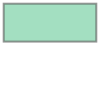

In [7]:
search_geo = box(*df_mgrs_overlapping.total_bounds)
search_geo

# Assign dates from event dict

In [8]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [9]:
resp = asf.geo_search(intersectsWith=search_geo.wkt,
                                 processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=PRE_DT_START, 
                                 end=POST_DT_STOP,
                                 relativeOrbit=event_dict['rtc_track_numbers']
                                )

In [10]:
df_rtc_resp = gpd.GeoDataFrame.from_features(resp.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp['acq_dt'] = pd.to_datetime(df_rtc_resp.startTime)
df_rtc_resp['acq_date'] = pd.to_datetime(df_rtc_resp.startTime).dt.round('D').dt.date

In [11]:
sorted(df_rtc_resp.acq_date.unique())

[datetime.date(2024, 4, 24),
 datetime.date(2024, 4, 25),
 datetime.date(2024, 5, 6),
 datetime.date(2024, 5, 7),
 datetime.date(2024, 5, 18),
 datetime.date(2024, 5, 19),
 datetime.date(2024, 5, 30),
 datetime.date(2024, 5, 31),
 datetime.date(2024, 6, 11),
 datetime.date(2024, 6, 12),
 datetime.date(2024, 6, 23),
 datetime.date(2024, 7, 5),
 datetime.date(2024, 7, 6),
 datetime.date(2024, 7, 17),
 datetime.date(2024, 7, 18),
 datetime.date(2024, 7, 29),
 datetime.date(2024, 7, 30),
 datetime.date(2024, 8, 10),
 datetime.date(2024, 8, 11),
 datetime.date(2024, 8, 22),
 datetime.date(2024, 8, 23),
 datetime.date(2024, 9, 3),
 datetime.date(2024, 9, 4),
 datetime.date(2024, 9, 15),
 datetime.date(2024, 9, 16)]

<Axes: >

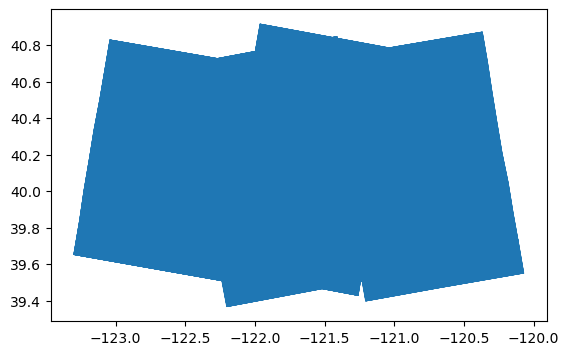

In [12]:
df_rtc_resp.plot()

# Save Data

In [13]:
burst_dir = Path('out') / event_dict['event_name'] / 'burst_data' 
burst_dir.mkdir(exist_ok=True, parents=True)
burst_dir

PosixPath('out/park_fire_2024/burst_data')

In [14]:
from requests.exceptions import HTTPError
from mpire import WorkerPool
import scipy.ndimage as ndimage
from skimage.measure import regionprops, label

def despeckle_one(
    X: np.ndarray, reg_param=5, noise_floor_db=-22, preserve_nans=True
) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(
        X_db, weight=1.0 / reg_param, isotropic=True, eps=1e-3
    )
    X_dspkl = np.power(10, X_db_dspkl / 10.0)

    data_mask = np.isnan(X_c).astype(bool)
    mask_labels = label(data_mask)
    
    exterior_mask_val = mask_labels[0, 0]
    assert all([exterior_mask_val == mask_labels[i, j] for i in [0, -1] for j in [0, -1]])
    exterior_mask = (mask_labels == exterior_mask_val).astype(np.uint8)

    exterior_mask_b = ndimage.binary_dilation(exterior_mask, iterations=4).astype(bool)
    
    if preserve_nans:
        X_dspkl[exterior_mask_b] = np.nan
    else:
         X_dspkl[exterior_mask_b] = 0
    X_dspkl = np.clip(X_dspkl, 0, 1)
    
    return X_dspkl

@backoff.on_exception(
    backoff.expo,
    [ConnectionError, HTTPError, RasterioIOError],
    max_tries=10,
    max_time=60,
    jitter=backoff.full_jitter,
)
def localize_one_rtc(
    url: str,
    ts_dir: str | Path
) -> Path:
    local_fn = url.split("/")[-1]
    out_path = ts_dir / local_fn
    if not ts_dir.exists():
        ts_dir.mkdir(parents=True)
    if out_path.exists():
        return out_path
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=16384): 
                f.write(chunk)
    return out_path


In [15]:
zipped_inputs = []
for (track_number, date), df_rtc_date in df_rtc_resp.groupby(['pathNumber', 
                                                              'acq_date']):
    print(track_number, date, df_rtc_date.shape[0])
    vh_urls = df_rtc_date.url.tolist()
    vv_urls = [url.replace('VH.tif', 'VV.tif') for url in vh_urls]
    ts_dir = burst_dir / f'track{str(track_number)}' / f'{str(date)}'
    ts_dir.mkdir(exist_ok=True, parents=True)
    localize_one_rtc_p = lambda url: localize_one_rtc(url, ts_dir=ts_dir)
    zipped_inputs.extend([(url, ts_dir) for url in vv_urls + vh_urls]) 

    

115 2024-04-24 15
115 2024-05-06 15
115 2024-05-18 15
115 2024-05-30 15
115 2024-06-11 15
115 2024-06-23 15
115 2024-07-05 15
115 2024-07-17 14
115 2024-07-29 15
115 2024-08-10 15
115 2024-08-22 15
115 2024-09-03 15
115 2024-09-15 15
137 2024-04-25 16
137 2024-05-07 16
137 2024-05-19 16
137 2024-05-31 16
137 2024-06-12 16
137 2024-07-06 16
137 2024-07-18 15
137 2024-07-30 16
137 2024-08-11 16
137 2024-08-23 16
137 2024-09-04 16
137 2024-09-16 16


In [16]:
def localize_one_rtc_p(data: tuple) -> Path:
    return localize_one_rtc(*data)
    
#localize_one_rtc_p(zipped_inputs[0])

In [17]:
# with WorkerPool(n_jobs=5, use_dill=True) as pool:
#     out_paths = pool.map(
#         localize_one_rtc,
#         zipped_inputs,
#         progress_bar=True,\
#         progress_bar_style="std",
#         concatenate_numpy_output=False,
#     )

In [18]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths = list(tqdm(executor.map(localize_one_rtc_p, zipped_inputs[:]), total=len(zipped_inputs)))

  0%|          | 0/770 [00:00<?, ?it/s]

100%|██████████| 770/770 [04:07<00:00,  3.11it/s]


# Merge data

In [19]:
change_dir_hls = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir_hls.mkdir(exist_ok=True, parents=True)
change_dir_hls

PosixPath('out/park_fire_2024/change_map_dist_hls')

In [20]:
change_map_tif = list(change_dir_hls.glob('*.tif'))[0]
with rasterio.open(change_map_tif) as ds:
    ref_profile_dist_hls = ds.profile

change_map_tif

PosixPath('out/park_fire_2024/change_map_dist_hls/dist_hls_provisional_change_map_veg_first2024-07-25.tif')

In [21]:
track_dirs = [burst_dir / f'track{t}' for t in event_dict["rtc_track_numbers"]]
acq_dirs = sorted([date_dir for track_dir in track_dirs for date_dir in track_dir.glob('*/')])
acq_dirs

[PosixPath('out/park_fire_2024/burst_data/track115/2024-04-24'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-05-06'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-05-18'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-05-30'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-06-11'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-06-23'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-07-05'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-07-17'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-07-29'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-08-10'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-08-22'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-09-03'),
 PosixPath('out/park_fire_2024/burst_data/track115/2024-09-15'),
 PosixPath('out/park_fire_2024/burst_data/track137/2024-04-25'),
 PosixPath('out/park_fire_2024/burst_data/track137/2024-05-07'),
 PosixPath('out/park_fire

In [22]:
from rasterio.merge import merge
from dem_stitcher.rio_tools import reproject_profile_to_new_crs
def merge_one_dir(acq_dir: Path, pol='VV', preserve_nans=True) -> list:
    assert pol in ['VV', 'VH']
    all_img_paths = list(acq_dir.glob(f'OPERA*{pol}.tif'))
    date_str = acq_dir.stem
    track_str = acq_dir.parent.stem
    acq_date_track_token = f'{date_str}_{track_str}'

    ts_dir = burst_dir.parent / 'rtc_ts_merged' / track_str 
    ts_dir.mkdir(exist_ok=True, parents=True)

    dst_path = ts_dir / f'merged_{acq_date_track_token}_{pol}.tif'

    if dst_path.exists():
        return dst_path

    def get_crs(p):
        with rasterio.open(p) as ds:
            crs = ds.crs
        return crs

    crs_l = [get_crs(path) for path in all_img_paths]
    def most_common(lst):
        """source: https://stackoverflow.com/a/1518632"""
        return max(set(lst), key=lst.count)
    ref_crs = most_common(crs_l)
    for path, crs in zip(all_img_paths, crs_l):
        if ref_crs != crs:
            with rasterio.open(path) as ds:
                X = ds.read(1)
                p = ds.profile
            prof_r = reproject_profile_to_new_crs(p, ref_crs)
            X_r, p_r = reproject_arr_to_match_profile(X, p, prof_r)
            # overwrite
            with rasterio.open(path, 'w', **p_r) as ds:
                ds.write(X_r)
    
    X_m, t_m = merge(all_img_paths, dtype='float32', method='first')
    with rasterio.open(all_img_paths[0]) as ds:
        p = ds.profile
    prof_merged = p.copy()
    prof_merged['transform'] = t_m
    prof_merged['count'] = X_m.shape[0]
    prof_merged['height'] = X_m.shape[1]
    prof_merged['width'] = X_m.shape[2]

    X_m_d = despeckle_one(X_m[0, ...], preserve_nans=preserve_nans)

    X_m_d_r, p_m_r = reproject_arr_to_match_profile(X_m_d, prof_merged, ref_profile_dist_hls)
    
    with rasterio.open(dst_path, 'w', **p_m_r) as ds:
        ds.write(X_m_d_r)
    
    return dst_path

In [23]:
# merge_one_dir(*merge_inputs[29])

In [24]:
merge_inputs = [(directory, pol) for directory in acq_dirs[:] for pol in ['VV', 'VH']]

with WorkerPool(n_jobs=5, use_dill=True) as pool:
    dst_paths = pool.map(
        merge_one_dir,
        merge_inputs,
        progress_bar=True,\
        progress_bar_style="std",
    )
# dst_paths = [merge_one_dir(directory, pol=pol) for directory in tqdm(acq_dirs[:]) for pol in ['VV', 'VH']]
dst_paths

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:09<00:00,  4.27s/it]


[PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-04-24_track115_VV.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-04-24_track115_VH.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-06_track115_VV.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-06_track115_VH.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-18_track115_VV.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-18_track115_VH.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-30_track115_VV.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-05-30_track115_VH.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-06-11_track115_VV.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-06-11_track115_VH.tif'),
 PosixPath('out/park_fire_2024/rtc_ts_merged/track115/merged_2024-06-23_track115_VV.tif'),

# Remove Source Burst Directory

In [25]:
import shutil

shutil.rmtree(burst_dir)